如果在足够多的数据上去做预训练，那我们也可以不用卷积神经网络，直接用一个从NLP那边搬过来的标准的transformer也能把视觉问题解决的很好。打破了CV和NLP的在模型上的壁垒

Intriguing Properties of Vision Transformers中举了一些例子说明在CNN上工作的不好，但是用vision transformer都处理的很好的例子。

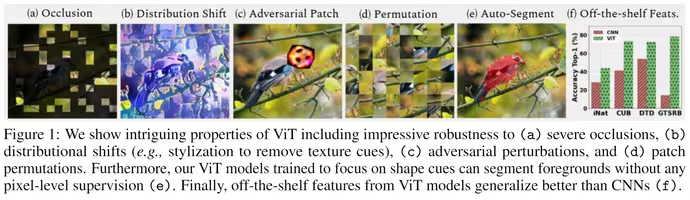

（a）遮挡，几乎看不出是一只鸟了（b）数据分布上有所偏移，这里就说对图片做了一次纹理去除（c）在鸟头上加了一个对抗性的patch（d）把图片打散了做排列组合。但所有这些例子vision transformer都能处理的很好。

**一张图片等价于很多16 * 16大小的单词，用transformer去做大规模的图像识别。**

为什么是16* 16，为什么是单词呢？就是把图片打成方格的形式，每个方格都是16* 16的patch，一张图片就是16* 16的很多patch组成的整体。

在视觉领域，自注意力要么是跟CNN一起用，要么就是把CNN中的卷积替换成自注意力，但还是**保持整体结构不变**。整体结构是指，比如一个残差网络比如 res50有四个stage：res2 res3 res4 res5，其实这个stage是不变的，**只是去取代每个stage每个block**。我们证明这种对CNN的依赖是不必要的，一个纯的transformer直接作用于一系列图像块的时候，也可以在图像分类任务上表现得很好，尤其是在大规模数据集上预训练，然后迁移到中小型数据集(ImageNet, CIFAR-100, VTAB, etc.其实不是中小数据集)的时候，vision transformer能获得跟最好的CNN网络相媲美的结果

## 把transformer用到CV上的难处
NLP中输入是一些元素（单词），输出也是一些元素，transformer里最主要的操作就是自注意力操作，就是每个元素相互之间都要互动，算一个attention，就是算得一个自注意力的图，用它去做加权平均，最后得到输出。

因为在做自注意力的时候，是两两相互的，就是计算复杂度是跟这个序列的长度是呈乘方倍的。目前在NLP中，现在硬件能支持的序列长度，一般是几百或者上千。比如BERT里是512的序列长度。


换到CV领域，首先第一个要解决的问题就是：如何把一个2d的图片变成一个1d的序列或者说变成一个集合，最直观的方式就是：把每个像素点当成序列的元素，直接把2d的图片拉直，扔到transformer里面自己跟自己去学去。但是想法很美好，实现起来复杂度很高。一般来说，在视觉任务里面，我们训练分类任务的时候，图片的输入大小大概是224* 224，如果把图片里的每个像素点，都直接当成元素来看，那它的序列长度就是224* 224=50176，一共5w个像素点，这就相当于是BERT的序列长度的100倍，这个复杂度是很可怕的（就是50176的乘方倍），如果图片更大就更恐怖了。

一些工作就把CNN和self-attention混到一起用（wang2018CVPR：像素点做输入序列太长，那就用网络中间的特征图作为transformer的输入，残差网络比如res50的stage4的时候特征图的size只有14* 14）。另外一些工作直接把CNN全换成self-attention了

（举了两个例子，stand-alone attention孤立自注意力和axial attention轴注意力。

1. 对于孤立自注意力：只用一个局部的窗口，通过控制窗口的大小来控制计算的复杂度，这有点相当于回到卷积的操作，因为卷积也是在一个局部的窗口里做的；

2. 对于轴自注意力的工作：对高度和宽度两个维度分别做self-attention，相当于把一个矩阵的self-attention变成了两个1d的按序操作，计算复杂度就大大降低了）。

其实这些工作都在做一件事：解决序列长度太长没法用transformer的问题，想办法降低序列长度。轴自注意力这种方法，虽然理论上是非常高效的，但是因为他们的自注意力操作都是比较特殊的自注意力操作无法硬件加速，所以很难去训练一个大模型，所以截止到目前为止孤立自注意力和轴注意力都还没有太大，与百亿千亿级别的transformer模型相比还是差的很远。




## 解决
假如图片大小是224* 224，打成16* 16的patch之后，输入的序列就是224/16=14,14* 14的一个序列，196的序列长度对于transformer来说是可以接受的。这样我们把一张图片打成patch，然后通过一个全连接层，得到一个linear embeddings，作为输入传给transformer。可以把这些image patch当成NLP里的单词，一个句子有多少词，就相当于一个图片有多少patch，这就是题目的意义：一个图片等价于很多16* 16的单词

vit就是使用标准Transformer，只需要对图片做一下预处理（把图片打成patch）然后送到transformer里，别的什么改动都不需要

当在中型大小的数据集上，例如imageNet去训练的时候，**如果不加比较强的约束，跟同等大小的残差网络相比是弱的**，弱几个点。这个看起来不太好的结果其实是可以预期的，因为transformer相比于CNN来说**缺少一些归纳偏置**（其实就是指一种先验知识，或者提前做好的假设，比如说对于CNN来说常见的有两个inductive bias：locality和translation equivariance，locality：因为CNN是以滑动窗口这种形式一点一点在图片上进行卷积的，假设图片上相邻的区域会有相邻的特征，这个假设当然是合理的，靠的越近的东西相关性越强。平移等变性：无论先做平移还是先做卷积最后的结果是一样的，不论图片中同样的物体移到了哪里，只要是同样的输入进来遇到了同样的卷积核，得到的输出永远是一样的）CNN有了这两个归纳偏置，就有了很多先验信息，所以就需要相对少的数据去学习比较好的模型。但是transformer都需要从数据里自己学。为了验证这个设想，vit就在大规模的数据集上做了实验，发现只要在足够大的数据集上预训练，就能在下游任务上获得很好的迁移学习效果。说明vit大规模的预训练比归纳偏置好。

策略：用NLP领域中标准的transformer做视觉问题，与之前工作不同的是，除了抽图像块和位置编码的时候用了一些图像特有的归纳偏置，除此之外就没有引入其他图像特有的归纳偏置了。好处就是不需要对视觉领域有所了解，或者需要domain knowledge。直接把图片理解为序列的图像块，就像句子里有很多单词一样。

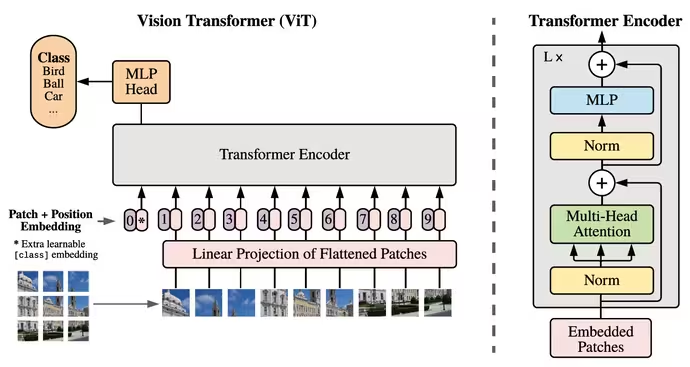

## 整体流程
首先给定一张图，先把图打成了patch，然后变成一个序列，每个patch会通过一个叫线性投射层的操作，得到一个特征（patch embedding），因为自注意力的两两交互，所以本身不考虑顺序问题，但是图片是一个整体，patch是有自己的顺序的，如果顺序颠倒了其实就不是原来那张图片了，同样类似NLP那边，给patch embedding加上了一个position embedding，加上之后这个整体的token就既包含了图片块原本有的图像信息，又包含了这个图像块所在的位置信息，其实得到了这些一个个的token，接下来就和NLP那边完全一样了，直接给transformer encoder，得到很多输出。但是那么多输出，我们该拿哪个去做最后的分类呢？再次借鉴bert，bert那边有extra learnable [class] embedding特殊字符CLS分类字符，同样的，本文中cls用* 代替，也是包含位置信息的，永远是0。因为所有的token都在和所有的token做交互，所以他们相信这个cls embedding能从其他embedding中学到有用的信息，从而我们只需要根据它的输出做最后判断就可以了。MLP head就是一个通用的分类头了。最后用交叉熵函数去进行模型的训练。

transformer encoder也是一个标准transformer，如右图这就是一个transformer block，叠加L次就得到了transformer encoder。

## 模型的前向过程
1、假如有一张图片（224* 224* 3），如果这里使用16 * 16patch size大小，就会得到224平方/16平方=196个图像块，每个图像块的维度（16* 16* 3=768）。所以我们就把224* 224* 3 的图片变成了有196个patch，每个patch的维度是768。

2、线性投射层：就是一个全连接层，文章中用E代表这个全连接层，维度是768* 768，**768就是文章中说的D，D是可变的，如果transformer变大D也可以相应的变大**，但是前面的768是图像patch算来的，这个是不变的。经过了这个线性投射就得到patch embedding，具体来说就是X* E，从维度上来说就是（197* 768）* （768* 768）=196* 768，就是现在有196个token每个token的维度是768。到这里，已经把一个视觉问题变成NLP问题了，输入已经是一系列1d的token，而不是一张2d的图了。

除了图像本身带来的token以外，还有一个额外的cls token（维度1* 768，方便和后面的图像信息直接拼接起来），所以最后序列的长度就是整体进入transformer的这个序列：（196+1）* 768。最后还要加上位置编码信息，讲到时说1-9编号，这只是一个序号，并不是我们真正使用的位置编码。具体做法是，有一个表，表中的每一行是一个向量，向量的维度也是768，这个向量也是可以学的，然后把这个位置信息加到所有的token里面，注意这里是加而不是拼接（是sum不是concatenation），所以加完位置编码信息之后这个序列还是197* 768。到此就做完了整个图片的预处理，包括加上位置编码和CLS。

3、transformer encoder的前向传播的过程：就是一个197* 768的Tensor，过一个layre norm还是197* 768。多头自注意力（变成三份kqv，每个都是197* 768。这里因为做的是多头自注意力，假设现在用的是vision transformer-base版本，也就是多头用的是12个头，这个维度就变成：768/12=64维，也就是kqv变成了197* 64，也就是有12个头做自注意操作，将12个头的输出直接拼接起来，这样64拼接出来又变成了768），所以多头自注意力出来的结果还是197* 768。维度过layernorm还是不变。MLP会相应放大，一般是放大四倍，所以就是197* 3072，然后再缩小投射回去就还是197* 768，就输出了。进去的时候197* 768，出来还是一样，序列长度和token大小都是一样的，所以就可以叠很多很多transformer block。

4、CLStoken，维度和图像特征维度相同，但只有一个token，经过很多层的transformer block，把它对应的输出当成整个transformer模型的输出，也就是当做整个图片的特征，一旦有这个图像特征后面就好做了，因为CNN到这里也是有一个图像的整体特征，在后面加一个MLP分类头就可以了。

## 消融实验
### cls token
了和原始的transformer保持一致，使用了cls token，和NLP一样，用来作为全局对句子理解的特征；在本文中就是当做图像的整体特征；

但之前在视觉领域不是这样做的，比如一个残差网络res50：前面有几个block（res2-res5），在最后一个stage输出一个feature map，再做一个globally average-pooling（gap）全局平均池化，得到的向量视为图片的整体特征，用来做分类。

为什么不能再transformer的n个输出上做全局平均池化GAP得到全局特征来做分类呢？作者用实验表明两种方式都可以，但是本文中使用cls token是为了尽可能和transformer保持一致，证明标准transformer也能做视觉。

但是CLS token和GAP方式的学习率不同，意味着需要好好的调参（调整学习率）

### 位置编码
1D：是nlp常用的位置编码，也就是本文使用的位置编码

2D：用d/2长度的两个向量分别表示横纵坐标，然后concat在一起，得到D维度的向量。为了整体的结构信息，更贴近视觉问题。

相对位置编码：比如2-9的位置差了7，就是相对距离

实验表明，不加位置编码效果比较差，因为transformer没有感知位置的能力；三种位置编码的方式效果都是一样的，可能的解释是：图像块的相对位置信息是比较容易得到的。

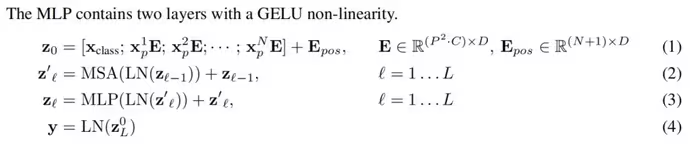
Z0是输入：

tokens： n个图像块的patch；每个patch和全连接层做转换得到patch embedding；拼接一个cls embedding；

给这些tokens加位置编码；

循环L次：

MSA多头自注意：

MLP全连接层：

都是先Layernorm。再残差连接。Zl'是自注意力的结果。Zl是整体结果。

y：CLStoken对应的输出，作为整体图像的特征

## 局限性
vit的微调局限：在微调的时候用更大的尺寸（>224×224），会得到更好的结果。但是预训练好的vit模型不好调输入尺寸：

若保持patch size不变，随着图片变大，序列长度会增加。理论上说transformer在硬件允许的情况下可以处理任意长度的序列，但是位置信息变了，9宫格可能变成16宫格，提前预训练好的位置编码就没用了。

这种情况可以通过做2d的插值解决，pytorch的interpalte函数就可以完成，但只是临时的解决方案，如果序列长度从很短变得很长，这种方法是会让最后的性能掉点的。

因为使用了图片的位置信息做插值，所以尺寸改变和抽图像块是vit中唯一使用2d信息的归纳偏置。